In [16]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

RANDOM_SEED=42

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Download Dataset

In [17]:
iris = load_iris()
X = iris['data']
y = iris['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1./3, random_state=RANDOM_SEED)

# Normalization

In [18]:
train_mean = np.mean(X_train)
train_std = np.std(X_train)

X_train_normalized = torch.from_numpy((X_train - train_mean) / train_std).float()
X_test_normalized = torch.from_numpy((X_test - train_mean) / train_std).float()

y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

# Datasets & Data Loaders

In [19]:
train_ds = TensorDataset(X_train_normalized, y_train)
train_dl = DataLoader(train_ds, batch_size=2, shuffle=True)

# Model Definition

In [20]:
class Model(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)
    
    
    def forward(self, x):
        x = self.layer1(x)
        x = torch.sigmoid(x)
        
        x = self.layer2(x)
        x = torch.softmax(x, dim=1)
        
        return x

In [21]:
model = Model(input_size=X_train_normalized.shape[1], hidden_size=16, output_size=3)

# Training Loop

In [22]:
def train(model: nn.Module, 
          optimizer: torch.optim.Optimizer, 
          loss_fn, 
          train_dl: DataLoader,
          num_epochs: int
    ) -> tuple:
    
    model.train()
    
    epochs_loss_history = []
    epochs_train_accuracy_history = []
    
    for epoch_index in range(num_epochs):
        
        epoch_loss_history = []
        epoch_train_accuracy_history = []
        
        for x_batch, y_batch in train_dl:
            predictions = model(x_batch)
            
            loss = loss_fn(predictions, y_batch)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            epoch_loss_history.append(loss.item())
            
            correct_predictions = (torch.argmax(predictions, axis=1) == y_batch).int()
            batch_correct_predictions_count = correct_predictions.sum().item()
            train_batch_accuracy = batch_correct_predictions_count / x_batch.shape[0]
            epoch_train_accuracy_history.append(train_batch_accuracy)
        
        epochs_loss_history.append(np.array(epoch_loss_history).mean())
        epochs_train_accuracy_history.append(np.array(epoch_train_accuracy_history).mean())
        
        print(f"Epoch {epoch_index + 1}/{num_epochs} | train_loss: {epochs_loss_history[epoch_index]:.4f} | train_acc: {epochs_train_accuracy_history[epoch_index]*100:.2f}%")
    
    return epochs_loss_history, epochs_train_accuracy_history

# Train Model

In [23]:
lr=0.001
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=lr)
num_epochs=100

epochs_loss_history, epochs_train_accuracy_history = train(model, optimizer, loss_fn, train_dl, num_epochs)

Epoch 1/100 | train_loss: 1.1023 | train_acc: 31.00%
Epoch 2/100 | train_loss: 1.0914 | train_acc: 31.00%
Epoch 3/100 | train_loss: 1.0821 | train_acc: 31.00%
Epoch 4/100 | train_loss: 1.0732 | train_acc: 42.00%
Epoch 5/100 | train_loss: 1.0653 | train_acc: 48.00%
Epoch 6/100 | train_loss: 1.0561 | train_acc: 62.00%
Epoch 7/100 | train_loss: 1.0468 | train_acc: 69.00%
Epoch 8/100 | train_loss: 1.0340 | train_acc: 65.00%
Epoch 9/100 | train_loss: 1.0210 | train_acc: 65.00%
Epoch 10/100 | train_loss: 1.0058 | train_acc: 67.00%
Epoch 11/100 | train_loss: 0.9902 | train_acc: 65.00%
Epoch 12/100 | train_loss: 0.9722 | train_acc: 65.00%
Epoch 13/100 | train_loss: 0.9552 | train_acc: 65.00%
Epoch 14/100 | train_loss: 0.9386 | train_acc: 65.00%
Epoch 15/100 | train_loss: 0.9245 | train_acc: 65.00%
Epoch 16/100 | train_loss: 0.9097 | train_acc: 65.00%
Epoch 17/100 | train_loss: 0.8977 | train_acc: 65.00%
Epoch 18/100 | train_loss: 0.8863 | train_acc: 65.00%
Epoch 19/100 | train_loss: 0.8760 | t

# Evaluate Neural Network Performance

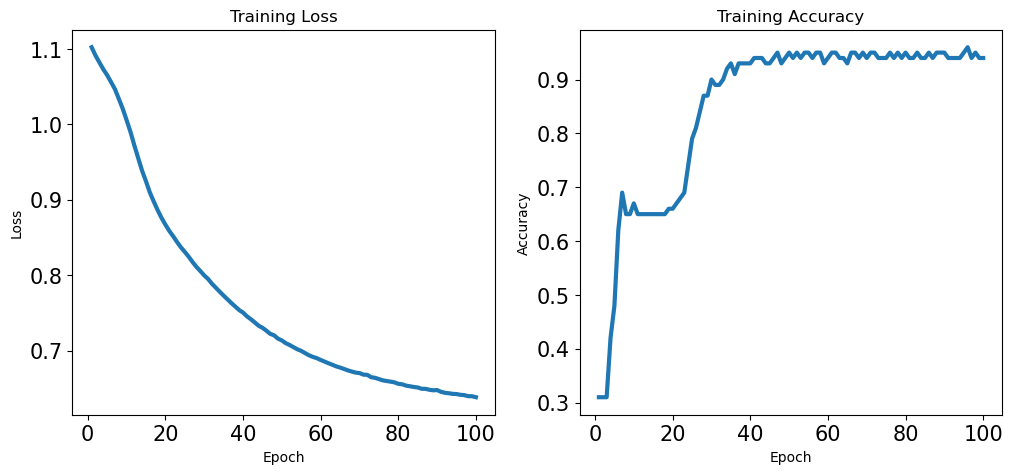

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
ax = axes.flatten()

epochs = np.arange(1, num_epochs + 1, 1)

ax[0].plot(epochs, epochs_loss_history, lw=3)
ax[0].set_title('Training Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].tick_params(axis='both', which='major', labelsize=15)

ax[1].plot(epochs, epochs_train_accuracy_history, lw=3)
ax[1].set_title('Training Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].tick_params(axis='both', which='major', labelsize=15)

# Test Set Performance Evaluation

In [25]:
pred_test = model(X_test_normalized)

correct_predictions = (torch.argmax(pred_test, dim=1) == y_test).float()
test_accuracy = correct_predictions.mean()
print(f"Test acc: {test_accuracy*100:.2f}%")

Test acc: 100.00%


# Saving Model Weights

In [26]:
torch.save(model.state_dict(), 'model_weights.pt')